# Clasificación de alimentos basada en reentrenamiento de la capa densa de la arquitectura VGG16

## Obtener el conjunto de datos Food-11

### Instalación de dependencias para acceder a Kaggle mediante su API

In [ ]:
!pip install kaggle

### Configuración del acceso a Kaggle mediante su API

In [1]:
import os

path_separator = "\\"
user_home = r"C:\Users\MG"
kaggle_path = ".kaggle"
kaggle_file = "kaggle.json"

kaggle_user = "..."
kaggle_token = "..."

path = user_home + path_separator + kaggle_path
if not os.path.exists(path):
    os.mkdir(path)
    print("Created path {}.".format(path))
else:
    print("Path {} already exists.".format(path))

filepath = path + path_separator + kaggle_file
if not os.path.exists(filepath):
    kaggle_json = "{\"username\":\"" + kaggle_user + "\",\"key\":\"" + kaggle_token + "\"}"
    f = open(filepath, "w")
    f.write(kaggle_json)
    f.close()
    print("Created file {} with username and key.".format(filepath))
else:
    print("File {} already exists.".format(filepath))

Path C:\Users\MG\.kaggle already exists.
File C:\Users\MG\.kaggle\kaggle.json already exists.


### Descargar conjunto de datos Food-11 desde Kaggle

In [2]:
import kaggle

https://www.kaggle.com/vermaavi/food11

Este conjunto de datos contiene 16643 imagenes de comida agrupadas en 11 grandes categorias. Estas categorias son Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, y Vegetable/Fruit. Es un conjunto de datos similar a Food-5K, y se encuentra dividido en tres partes: entrenamiento (training), validación (validation) y evaluación (evaluation). La convención de nombres usada es {ClassID}_{ImageID}.jpg, donde ID corresponde a un número del 0 al 10 que refiere a alguna de las 11 categorias de comida mencionadas.

In [7]:
!kaggle datasets list -s Food-11

ref                                               title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
vermaavi/food11                                   Food-11                                           2GB  2019-06-05 19:51:16           1079         24  0.6875           
trolukovich/food11-image-dataset                  Food-11 image dataset                             1GB  2019-12-02 16:39:54            432         16  0.875            
dorbicycle/world-foodfeed-production              Who eats the food we grow?                      874KB  2017-11-30 06:32:35           8852        333  0.85294116       
borapajo/food-choices                             Food choices                                      5MB  2017-04-23 14:04:43          18069        292

In [8]:
!kaggle datasets download -d vermaavi/food11


  0%|          | 0.00/2.17G [00:00<?, ?B/s]
  0%|          | 1.00M/2.17G [00:00<14:08, 2.74MB/s]
  0%|          | 2.00M/2.17G [00:00<13:49, 2.80MB/s]
  0%|          | 3.00M/2.17G [00:01<13:11, 2.94MB/s]
  0%|          | 4.00M/2.17G [00:01<13:27, 2.87MB/s]
  0%|          | 5.00M/2.17G [00:01<12:34, 3.08MB/s]
  0%|          | 6.00M/2.17G [00:01<11:20, 3.41MB/s]
  0%|          | 7.00M/2.17G [00:02<10:46, 3.59MB/s]
  0%|          | 8.00M/2.17G [00:02<12:27, 3.10MB/s]
  0%|          | 9.00M/2.17G [00:02<11:41, 3.30MB/s]
  0%|          | 10.0M/2.17G [00:03<10:59, 3.51MB/s]
  0%|          | 11.0M/2.17G [00:03<10:41, 3.61MB/s]
  1%|          | 12.0M/2.17G [00:03<10:44, 3.59MB/s]
  1%|          | 13.0M/2.17G [00:04<11:11, 3.44MB/s]
  1%|          | 14.0M/2.17G [00:04<10:57, 3.52MB/s]
  1%|          | 15.0M/2.17G [00:04<11:13, 3.43MB/s]
  1%|          | 16.0M/2.17G [00:05<11:46, 3.27MB/s]
  1%|          | 17.0M/2.17G [00:05<11:43, 3.28MB/s]
  1%|          | 18.0M/2.17G [00:05<11:23, 3.37MB/s]
 

### Desempaquetar el conjunto de datos Food-11

In [9]:
import zipfile

dataset_file = "food11.zip"
data_path = "data"

if not os.path.exists(data_path):
    os.mkdir(data_path)
    print("Created path {}.".format(data_path))
else:
    print("Path {} already exists.".format(data_path))

path_separator = "\\"
food11_path = data_path + path_separator + "food-11"

if not os.path.exists():
    with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
        zip_ref.extractall(data_path)
    print("Food-11 dataset unpacked to path {}.".format(food11_path))
else:
    print("Food-11 dataset already available at {}.".format(food11_path))

## Entrenamiento de la capa densa de la red VGG16 y validación

### Dependencias requeridas

In [1]:
#import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 

In [2]:
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score

### Verificación de GPU disponibles

In [6]:
import tensorflow as tf

print("Number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPUs available:  1


### Codificación ONE HOT del conjunto de datos

In [7]:
train = [os.path.join("data\\food-11\\training",img) for img in os.listdir("data\\food-11\\training")]
val = [os.path.join("data\\food-11\\validation",img) for img in os.listdir("data\\food-11\\validation")]
test = [os.path.join("data\\food-11\\evaluation",img) for img in os.listdir("data\\food-11\\evaluation")]

In [8]:
len(train),len(val),len(test)

(9866, 3430, 3347)

In [9]:
train[0:10]

['data\\food-11\\training\\0_0.jpg',
 'data\\food-11\\training\\0_1.jpg',
 'data\\food-11\\training\\0_10.jpg',
 'data\\food-11\\training\\0_100.jpg',
 'data\\food-11\\training\\0_101.jpg',
 'data\\food-11\\training\\0_102.jpg',
 'data\\food-11\\training\\0_103.jpg',
 'data\\food-11\\training\\0_104.jpg',
 'data\\food-11\\training\\0_105.jpg',
 'data\\food-11\\training\\0_106.jpg']

In [10]:
train[0].split("\\")[-1].split("_")[0]

'0'

In [11]:
train_y = [int(img.split("\\")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("\\")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("\\")[-1].split("_")[0]) for img in test]

In [12]:
train_y[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
# Conversión de observaciones (imagenes) en vectores según clase 
num_classes = 11
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

In [14]:
y_train[0:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Observaciones (imagenes) para entrenamiento disponibles por clase

Datos de entrenamiento disponibles en 11 clases
[994, 429, 1500, 986, 848, 1325, 440, 280, 855, 1500, 709]


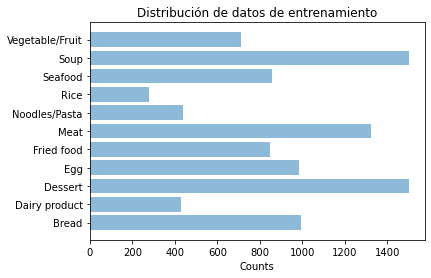

In [30]:
print("Datos de entrenamiento disponibles en 11 clases")
print([train_y.count(i) for i in range(0,11)])
 
food_classes = ('Bread','Dairy product','Dessert','Egg','Fried food','Meat',
           'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit')
 
y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(0,11)]
 
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Cantidad')
plt.title('Distribución de datos de entrenamiento')
 
plt.show()

In [32]:
print("Datos de validación disponibles en 11 clases")
[val_y.count(i) for i in range(0,11)]

Datos de validación disponibles en 11 clases


[362, 144, 500, 327, 326, 449, 147, 96, 347, 500, 232]

In [33]:
print("Datos de evaluación disponibles en 11 clases")
[test_y.count(i) for i in range(0,11)]

Datos de evaluación disponibles en 11 clases


[368, 148, 500, 335, 287, 432, 147, 96, 303, 500, 231]

In [30]:
def show_imgs(X):
    plt.figure(figsize=(10, 10))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()

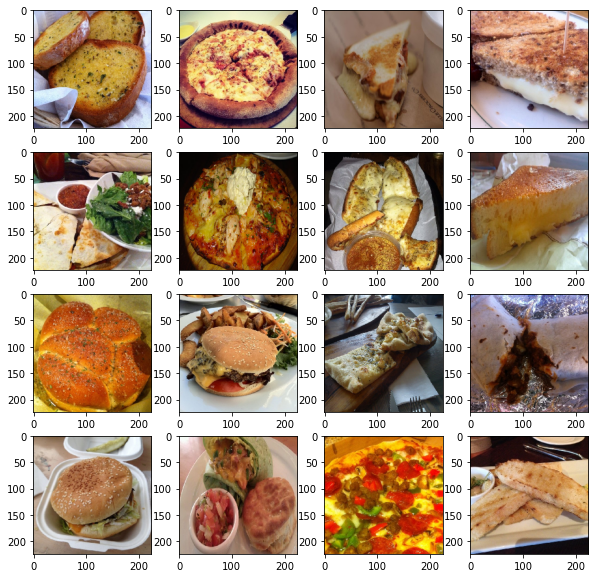

In [31]:
show_imgs(train)

### Creción de features a partir de imagenes del conjunto de datos

In [18]:
def create_features(dataset):
    x_scratch = []

    for imagePath in dataset:
 
        # carga imagen de entrada y cambia su tamaño a 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocesa la imagen (1) expandiendo su dimensión y
        # (2) restando la media de la intensidad de pixel RGB pixel 
        # correspondiente al conjunto de datos de ImageNet
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # agrega la imagen al batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    return x

In [19]:
train_x = create_features(train)
print(train_x.shape)

(9866, 224, 224, 3)


In [20]:
val_x = create_features(val)
print(val_x.shape)

(3430, 224, 224, 3)


In [21]:
test_x = create_features(test)
print(test_x.shape)

(3347, 224, 224, 3)


### Creación de la red neuronal convolucional (CNN) basada en arquitectura VGG16

In [22]:
# Crea checkpointer
checkpointer = ModelCheckpoint(filepath='food.model.best.hdf5',
                               verbose=1,save_best_only=True)
# Carga la red VGG16
print("[Inicialización de CNN...")
model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
model_vgg.summary()

[INFO loading network...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 

### Agregado de capa densa a CNN

In [23]:
model_transfer_full = Sequential()
model_transfer_full.add(model_vgg)
model_transfer_full.add(GlobalAveragePooling2D())
model_transfer_full.add(Dropout(0.2))
model_transfer_full.add(Dense(100, activation='relu'))
model_transfer_full.add(Dense(11, activation='softmax'))
model_transfer_full.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 14,767,099
Trainable params: 14,767,099
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento de la red para clasificación de alimentos

In [24]:
opt = Adam(lr=0.00001)
model_transfer_full.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model_transfer_full.fit(train_x, y_train, batch_size=32, epochs=10,
          validation_data=(val_x, y_val), callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/10
309/309 [==============================] - ETA: 0s - loss: 1.8999 - accuracy: 0.4002
Epoch 00001: val_loss improved from inf to 1.06774, saving model to food.model.best.hdf5
309/309 [==============================] - 1094s 4s/step - loss: 1.8999 - accuracy: 0.4002 - val_loss: 1.0677 - val_accuracy: 0.6563
Epoch 2/10
309/309 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.7042
Epoch 00002: val_loss improved from 1.06774 to 0.74949, saving model to food.model.best.hdf5
309/309 [==============================] - 1200s 4s/step - loss: 0.9128 - accuracy: 0.7042 - val_loss: 0.7495 - val_accuracy: 0.7659
Epoch 3/10
309/309 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.7966
Epoch 00003: val_loss improved from 0.74949 to 0.60476, saving model to food.model.best.hdf5
309/309 [==============================] - 1140s 4s/step - loss: 0.6368 - accuracy: 0.7966 - val_loss: 0.6048 - val_accuracy: 0.8105
Epoch 4/10
309/309 [==================

### Resultados de la red entrenada

In [27]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim([0, 1])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

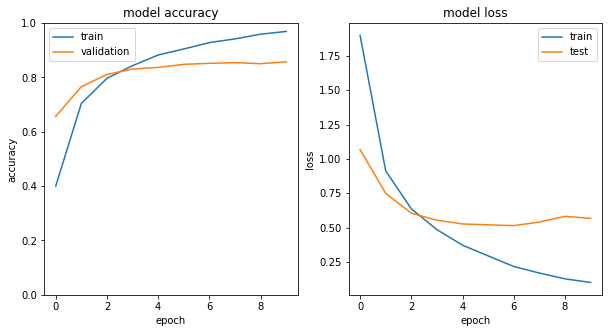

In [28]:
plot_accuracy_loss(history)

In [29]:
preds = np.argmax(model_transfer_full.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified images: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,11))


Accuracy on Test Data:  0.8754108156558111

Number of correctly identified images:  2930 



array([[282,   0,  18,  12,  20,  18,   0,   4,   9,   3,   2],
       [  3, 103,  18,   2,   2,   6,   0,   3,   5,   2,   4],
       [  5,  13, 397,  10,   4,  31,   0,   2,  22,   9,   7],
       [ 20,   1,  10, 270,   5,  13,   1,   2,  10,   3,   0],
       [  1,   1,   8,   0, 253,  19,   0,   2,   2,   0,   1],
       [  1,   0,   5,   1,   5, 411,   0,   1,   4,   1,   3],
       [  0,   0,   0,   0,   1,   0, 143,   2,   0,   1,   0],
       [  0,   0,   2,   0,   1,   0,   0,  93,   0,   0,   0],
       [  2,   0,   7,   1,   1,  11,   0,   1, 276,   1,   3],
       [  2,   0,   6,   0,   1,   3,   0,   2,   3, 483,   0],
       [  0,   0,   4,   0,   2,   5,   1,   0,   0,   0, 219]],
      dtype=int64)

### Cargar el modelo de clasificación generado e identificar alimentos

In [34]:
from keras.models import load_model

model = load_model("food.model.best.hdf5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 14,767,099
Trainable params: 14,767,099
Non-trainable params: 0
_________________________________________________________________
